# Community Enrichment Analysis

Here I perform Gene Ontology enrichment analysis on each of the 577 communities produced by the infomap community detection algorithm, detailed in the following notebook:

https://github.com/wigasper/viral-mirna-database/blobl/master/exploratory_network_analysis.md

I am interested in the what proportion of community members share any significantly enriched Gene Ontology terms. This may provide insight as to why target genes or communities of target genes ended up as targets of Epstein-Barr virus, and it also may potentially serve as validation for the infomap community detection algorithm. Some of this is fairly intuitive and to be expected: gene products that interact with each other tend to be part of the same biological processes and located in the same locations. Thus, it could be expected that each community will have significantly enriched GO terms, and many members of each community will share some of these significantly enriched GO terms.

I used the [GOATools package](https://github.com/tanghaibao/goatools) with their [Run a Gene Ontology Enrichment Analysis notebook](https://github.com/tanghaibao/goatools/blob/master/notebooks/goea_nbt3102.ipynb) as a guide to help me get started and provide some code.

In [ ]:
import psycopg2
from goatools.obo_parser import GODag
from goatools.associations import read_ncbi_gene2go
from goatools.test_data.genes_NCBI_9606_ProteinCoding import GENEID2NT as gene_id_2_nt
from goatools.go_enrichment import GOEnrichmentStudy

## Conversion of Gene Symbols to Gene IDs
I conducted my [exploratory analysis](https://github.com/wigasper/viral-mirna-database/blobl/master/exploratory_network_analysis.md) using gene symbols, and I need to convert these to gene IDs to play nicely with GOATools. To do this I use psycopg2 to query my database (which contains both symbols and gene IDs for each gene) and make a dictionary to do the conversion.

In [4]:
# Create connection
conn = psycopg2.connect(database="vir_mirna", user="wkg", 
                        password="apples", host="localhost")

# Create cursor
cursor = conn.cursor()

# Query
cursor.execute("SELECT protein.symbol, protein.gene_id "
               "FROM protein, viral_mirna, viral_target "
               "WHERE protein.uniprot_id = viral_target.uniprot_id "
               "AND viral_target.vi_mirna_id = viral_mirna.vi_mirna_id "
               "AND viral_mirna.virus = 'EBV';")

results = cursor.fetchall()

# Make dict
gene_to_symbol = dict(results)

## Read in Community Data

In [5]:
# Get EBV targets to subset membership
ebv_targets = []
with open("./data/ebv_target_symbols.csv", "r") as fp:
    for line in fp:
        line = line.strip("\n")
        ebv_targets.append(line)

# Read in membership data and convert to symbols to gene IDs
membership = []
with open("./data/protein_community_membership.csv", "r") as fp:
    for line in fp:
        line = line.strip("\n")
        line = line.split(",")
        if line[0] in ebv_targets and gene_to_symbol[line[0]] is not None:
            membership.append([gene_to_symbol[line[0]], int(line[1])])

# Extract community IDs
communities = [comm[1] for comm in membership]
# Remove duplicates
communities = list(dict.fromkeys(communities))

## GO Enrichment Analysis Setup

In [ ]:
obodag = GODag("./data/go.obo")
geneid2gos = read_ncbi_gene2go("./data/gene2go", taxids=[9606])

goeaobj = GOEnrichmentStudy(
        gene_id_2_nt.keys(), # human protein coding genes
        geneid2gos, # geneid/GO associations
        obodag, # Ontologies
        propagate_counts = False,
        alpha = 0.05, # default significance cut-off
        methods = ['fdr_bh']) # defult multipletest correction method

In [ ]:
# Run GO enrichment analysis for each community
comm_enrich_scores = []
for community in communities:
    subset = [gene[0] for gene in membership if gene[1] == community]

    goea_results = goeaobj.run_study(subset);
    sig_results = [result for result in goea_results if result.p_fdr_bh < 0.05]
    
    enriched_mem_ratios = []
    for res in sig_results:
        enriched_mem_ratios.append(res.ratio_in_study[0] / res.ratio_in_study[1])
    
    if len(enriched_mem_ratios):
        avg_enriched_ratio = sum(enriched_mem_ratios) / len(enriched_mem_ratios)
        comm_enrich_scores.append([community, avg_enriched_ratio])

100%      3 of      3 study items found in association
100%      3 of      3 study items found in population(20913)
Calculating 17,999 uncorrected p-values using fisher_scipy_stats
  17,999 GO terms are associated with 18,480 of 20,913 population items
      39 GO terms are associated with      3 of      3 study items
       0 GO terms found significant (< 0.05=alpha) after multitest correction: statsmodels fdr_bh
100%      8 of      8 study items found in association
100%      8 of      8 study items found in population(20913)
Calculating 17,999 uncorrected p-values using fisher_scipy_stats
  17,999 GO terms are associated with 18,480 of 20,913 population items
     109 GO terms are associated with      8 of      8 study items
       8 GO terms found significant (< 0.05=alpha) after multitest correction: statsmodels fdr_bh
100%     11 of     11 study items found in association
100%     11 of     11 study items found in population(20913)
Calculating 17,999 uncorrected p-values using fi

## Community Enrichment Analysis Results

First, let's see how many of our communities contain members with significantly enriched GO terms:

In [39]:
print(str(len(comm_enrich_scores) / len(communities)))

1.0


Not terribly promising, but we don't really have any basis for evaluation here. I would have to try a number of different community detection algorithms with a variety of parameters to get a better idea for what this could look like.

We can use a kernel density plot to help visualize the results of performing GO enrichment analysis on each community. This graph shows the distribution of enrichment frequencies, where an enrichment frequency is the average number of community members that contained significantly enriched GO terms. As mentioned earlier, we would expect community members to contain similar GO terms, because proteins tend to interact with other proteins involved in the same processes.

This basic method could be expanded and made significantly more robust in order to evaluate community detection algorithms. 

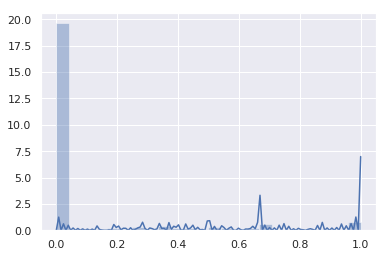

In [36]:
import seaborn as sns
#import numpy as np

freqs = [score[1] for score in comm_enrich_scores]
#freqs = np.array(freqs)

sns.set(color_codes=True)
#sns.kdeplot(freqs, shade=True)
sns.distplot(freqs)

Let's also find the number of communities where greater than 50% of community members shared significantly enriched GO terms:

In [27]:
print(str(len([comm for comm in comm_enrich_scores if comm[1] >= .5]) / len(comm_enrich_scores)))

0.10918544194107452


In [28]:
len(comm_enrich_scores)

577

In [38]:
len(communities)

577

In [31]:
freqs

[0,
 0.46875,
 0.284090909090909,
 0.13939393939393935,
 0.5416666666666666,
 0.04347779446470715,
 0,
 0.2739130434782609,
 0.36458333333333337,
 0.20094936708860758,
 0,
 0.52,
 0.19341176470588228,
 1.0,
 0,
 0.6666666666666666,
 0.26495726495726496,
 0,
 0.3333333333333333,
 0,
 0.4444444444444444,
 0,
 0.35,
 0,
 0,
 0.2050438596491228,
 0.1916592724046141,
 0,
 0.37499999999999994,
 0.3928571428571428,
 0.7619047619047619,
 0.4,
 0,
 0.3416666666666667,
 0.19047619047619047,
 0.27450980392156865,
 0,
 0,
 0,
 0,
 0,
 0.31666666666666665,
 0,
 0,
 0,
 0.3055555555555555,
 0.3412698412698412,
 0.55,
 0.5,
 0.24175824175824173,
 0.9375,
 0.3361344537815125,
 0,
 0,
 0.5,
 0,
 0,
 0,
 0,
 0.21666666666666665,
 0,
 0,
 0,
 0,
 0,
 0,
 0.425,
 0,
 0,
 0.4444444444444444,
 0,
 0.390625,
 0.13333333333333333,
 0.38423645320197053,
 0,
 0,
 0.22610722610722603,
 0,
 0.2857142857142857,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1.0,
 0.6272727272727274,
 0.6666666666666666,
 0,
 0.6428571428571